In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import pickle
from generating_images import *
import PIL
import seaborn as sns
from scipy.signal import *

pt = 0.3528 # mm/point, size of a font
px_size = 0.100 # electrode pixel size in mm

## Important note for Sloan and optometrist fonts

Only the letters CDHKNORSVZ are designated as the standard for acuity testing by the american authorities. The Sloan font extends to the complete uppercase alphabet, but the letters are not recognized as official testing letters. **The C is a Landolt C**. The font has no descenders, the height and width are equal to the nominal point size requested. Adjoining characters touch each others. <br>

According to Louis Sloan: *The design of the letters follows the Snellen principle in that the over-all height and width are five times the width of the strokes. The letters are of the familiar Gothic form and therefore differ from the Snellen capital letters in that the serifs are omitted.* The Landolt C has a gap width the size of a stroke width, which is a fifth of the overall letter size.<br>

The typography Point used as font size is defined as: **1 point = 1/72 inch = 0.3528 mm** <br>

Sources: 
 - [GitHub Eye-Chart-Fonts](https://github.com/denispelli/Eye-Chart-Fonts/)
 - [Wikipedia Typeface anatomy](https://en.wikipedia.org/wiki/Typeface_anatomy)
 - [Wikipedia Point (typography)](https://en.wikipedia.org/wiki/Point_(typography))
 - [Louis' Sloan paper](https://doi.org/10.1016/0002-9394(59)90626-9)


## First tests

### Testing basic shapes, and text

In [2]:
def generate_image_with_frame(width, height, objects, frame_width):
    # Create a blank white image
    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)
    
    font = ImageFont.load_default()
    #font = ImageFont.truetype("Solan.otf", size=60)  # Adjust the font size as needed

    # Draw a red square frame around the entire image
    draw.rectangle([0, 0, width - 1, height - 1], outline="red", width=frame_width)
    for obj in objects:
        if obj["type"] == "square":
            x, y, size, color = obj["x"], obj["y"], obj["size"], obj["color"]
            draw.rectangle([x, y, x + size, y + size], fill=color)
        elif obj["type"] == "circle":
            x, y, size, color = obj["x"], obj["y"], obj["size"], obj["color"]
            draw.ellipse([x, y, x + size, y + size], fill=color)
        elif obj["type"] == "text":
            x, y, text, font_size, font_color = obj["x"], obj["y"], obj["text"], obj["font_size"], obj["font_color"]
            #font = ImageFont.truetype("arial.ttf", font_size)
            draw.text((x, y), text, font=font, fill=font_color)
    return image

In [3]:
def generate_grating(width, height, frame_width, spatial_frequency, angle_degrees):
    # Create a blank white image
    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)

    # Convert angle to radians
    angle_radians = np.deg2rad(angle_degrees)
    # Compute the wavelength of the grating
    wavelength = 1 / spatial_frequency
    for x in range(width):
        for y in range(height):
            # Compute the position in the direction of the grating
            position = x * np.cos(angle_radians) + y * np.sin(angle_radians)
            # Compute the brightness of the pixel based on the position
            brightness = 255 if np.sin(2 * np.pi * position / wavelength) > 0 else 0
            # Set the pixel color
            draw.point((x, y), fill=(brightness, brightness, brightness))

    # Draw a red square frame around the entire image
    draw.rectangle([0, 0, width - 1, height - 1], outline="red", width=frame_width)

    return image

In [4]:
# Example usage:

# Type of objects to draw
objects = [
    {"type": "square", "x": 50, "y": 50, "size": 100, "color": "red"},
    {"type": "circle", "x": 200, "y": 100, "size": 80, "color": "blue"},
    {"type": "text", "x": 150, "y": 300, "text": "THIS IS A TEXT WITH default font", "font_size": 36, "font_color": "green"},
]

# Image size, frame characteristics
width, height = 400, 400
frame_width = 10

# Grating specs
spatial_frequency = 0.2  # Adjust the spatial frequency as needed
angle_degrees = 45  # Adjust the angle of the grating as needed

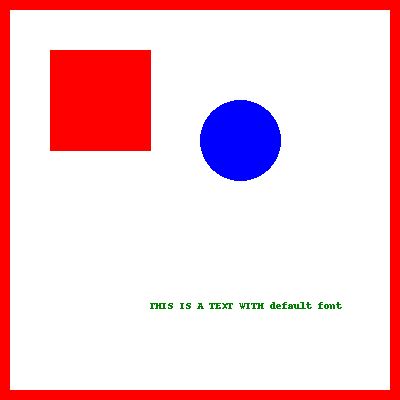

In [5]:
image_objects = generate_image_with_frame(width, height, objects, frame_width)
image_objects

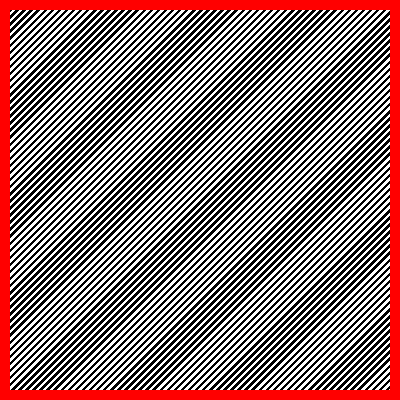

In [6]:
image_grating = generate_grating(width, height, frame_width, spatial_frequency, angle_degrees)
image_grating.save("generated_grating3.bmp")
image_grating

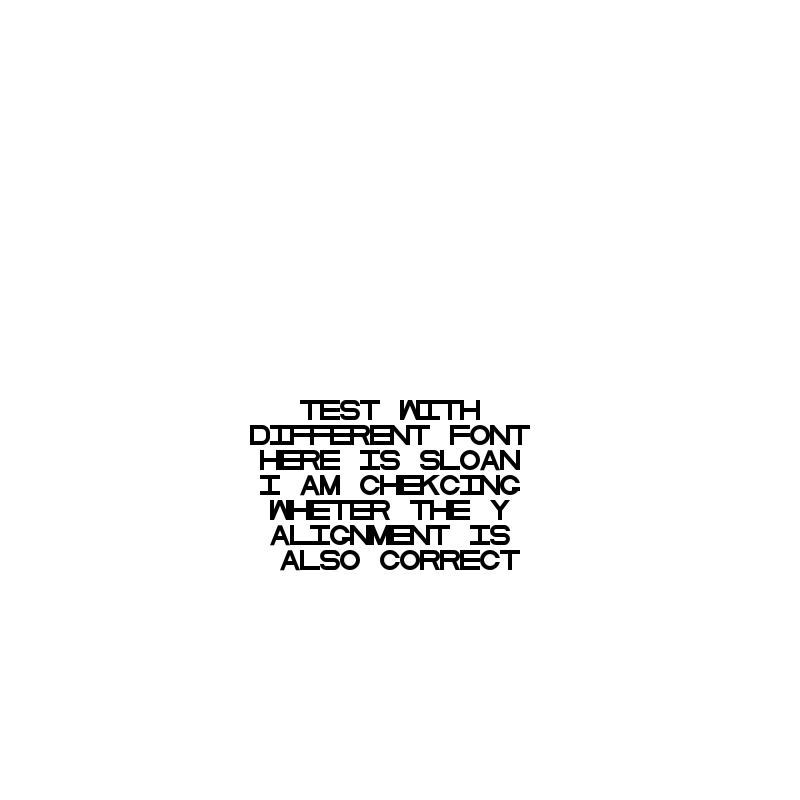

In [7]:
# Test cell 
width, height = 800, 800    

image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

font = ImageFont.truetype('../Sloan.otf', size=20)  # Adjust the font size as needed

center_x, center_y = int(width/2), int(height/2)
text = 'TEST WITH \nDIFFERENT FONT \nHERE IS SLOAN \nI AM CHEKCING \nWHETER THE Y \nALIGNMENT IS \nALSO CORRECT'

center_x -= determine_text_offset(text, draw, font)
draw.text((center_x, center_y), text, font=font, fill="black", align='center')
image

## Testing with actual patterns

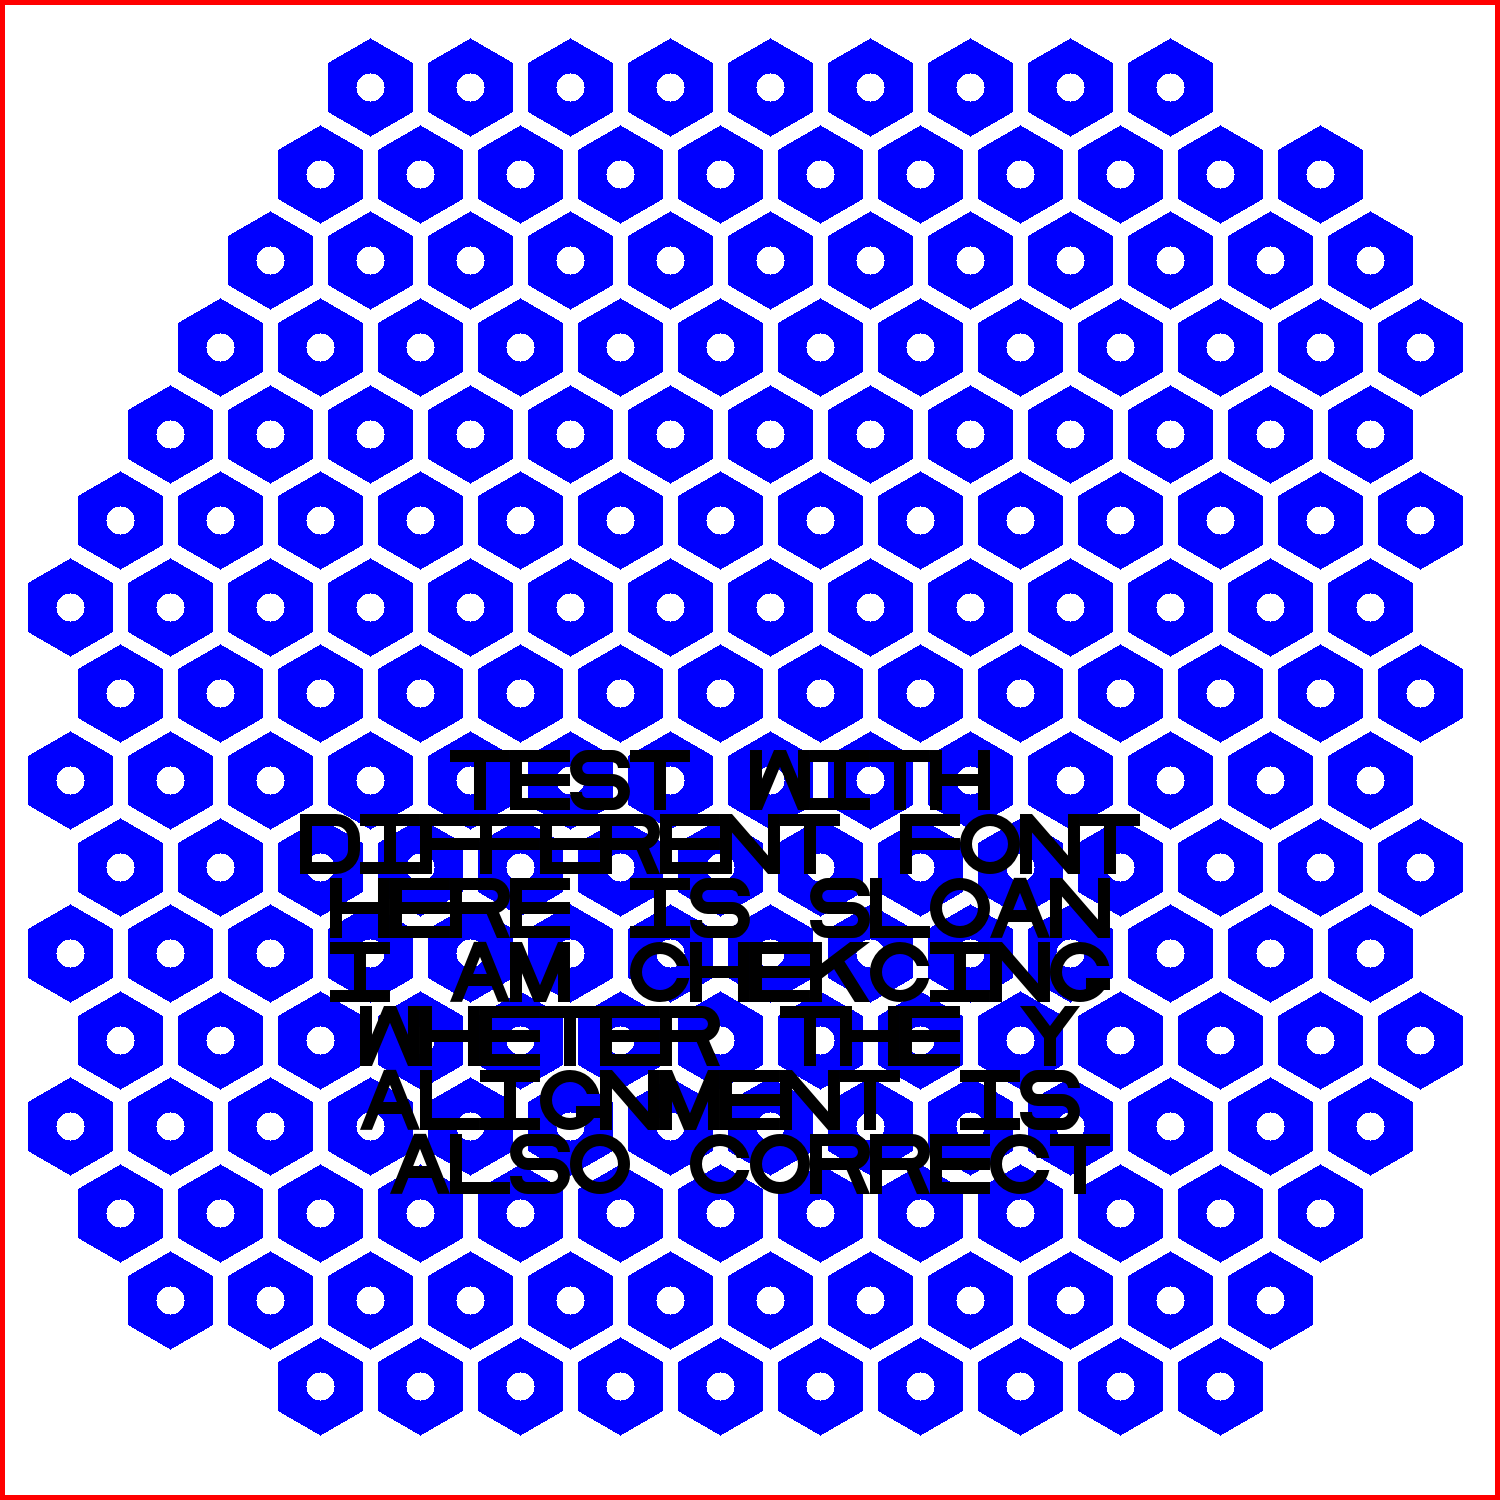

In [2]:
path = "../user_files/user_input/image_sequence/Grid_PS100.png"
background = Image.open(path, 'r')
width, height = background.size

# Convert the pixel pattern into a PIL drawing
draw = ImageDraw.Draw(background)
# Compute the font size 
im_px_size = 2 / 1500 # mm/px

font_size = 60
font = ImageFont.truetype('../Sloan.otf', size=font_size)  # Adjust the font size as needed

center_x, center_y = int(width/2), int(height/2)
text = 'TEST WITH \nDIFFERENT FONT \nHERE IS SLOAN \nI AM CHEKCING \nWHETER THE Y \nALIGNMENT IS \nALSO CORRECT'

center_x -= determine_text_offset(text, draw, font)
draw.text((center_x, center_y), text, font=font, fill="black", align='center')

background

### New tests for rotating the letters

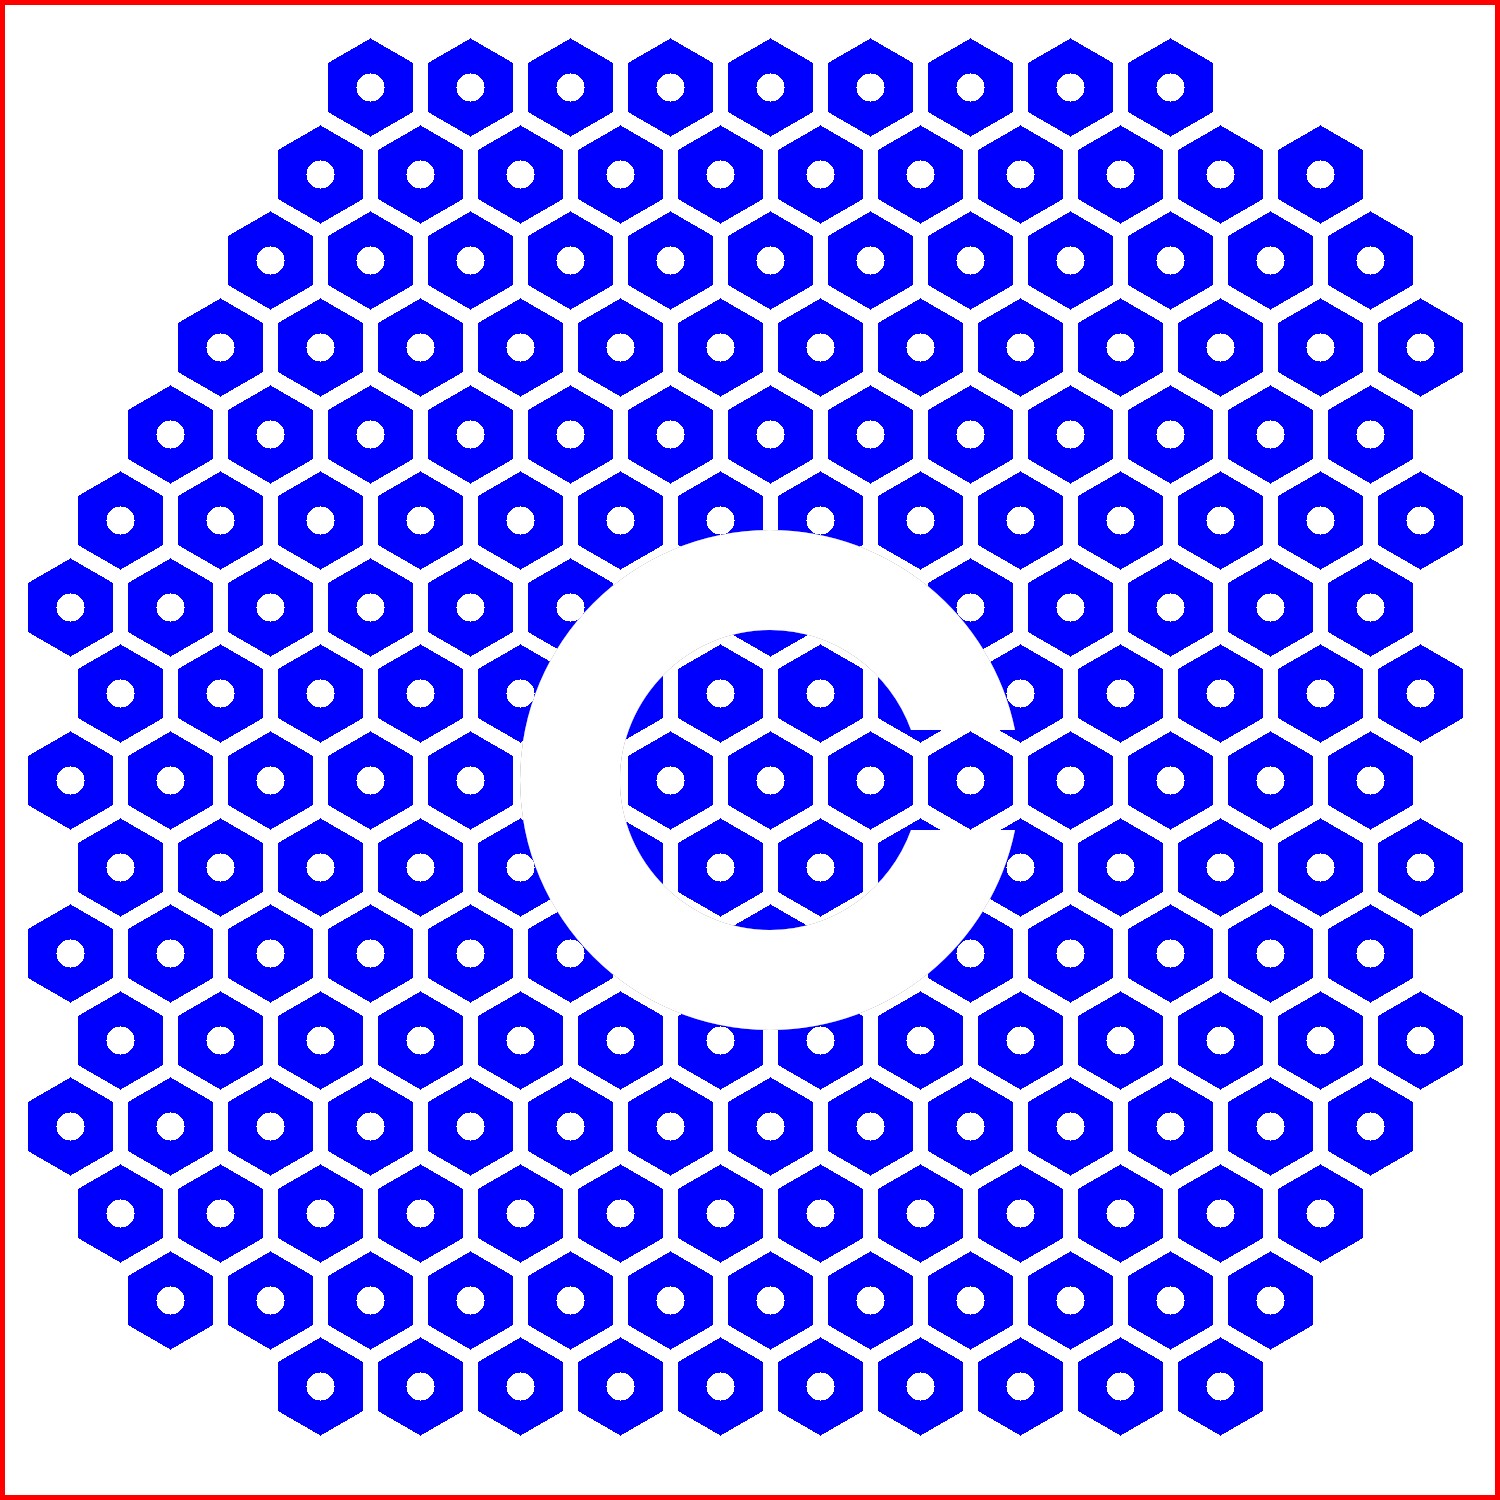

In [3]:
electrode_pixel_size = 100
electrode_label_number = 99
text = 'C'
letter_size = 5
position = (0, 0)
image_width = 1500 

# Define the size of the text image - TODO adapt for more than one letter
image_size = (electrode_pixel_size * letter_size, electrode_pixel_size * letter_size)

# Create a new image with a transparent background
text_image = Image.new('RGBA', image_size, (0, 0, 0, 0))

# Convert to drawing, set the font and write
text_drawing = ImageDraw.Draw(text_image)
font, center_x, center_y = determine_location_letter(electrode_pixel_size, electrode_label_number, text, letter_size, position)
text_drawing.text((0, 0), text, font=font, fill="white", align='center')

text_image = text_image.rotate(0, PIL.Image.NEAREST, expand = 1)
text_image.save("test.png")

# Merge onto the background
path = f"../user_files/user_input/image_sequence/Grid_PS{electrode_pixel_size}.png"
background = Image.open(path, 'r')

# Compute the new position taking into account the offset
center_x -= text_image.size[0]/2
center_y -= text_image.size[1]/2
position = (int(center_x), int(center_y))
background.paste(text_image, position, text_image)
background

## Test to find the central electrode 
A test for finding the location of the central electrode.

Tests with label files

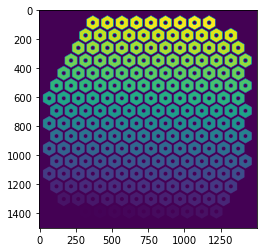

In [8]:
# Test cell 
file = '../user_files/user_input/image_sequence/pixel_label_PS100.pkl'
with open(file, 'rb') as f:
    label = pickle.load(f)
plt.imshow(label)

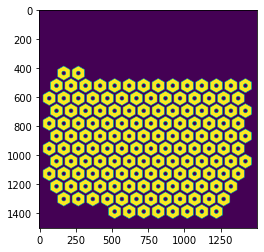

In [10]:
mask = (label > 2) & (label < 150)
plt.imshow(mask)

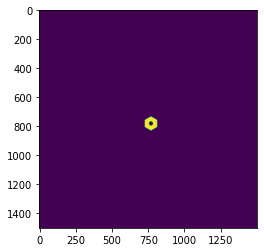

In [11]:
mask = label == 99
plt.imshow(mask)

### The distance matrix

<AxesSubplot:>

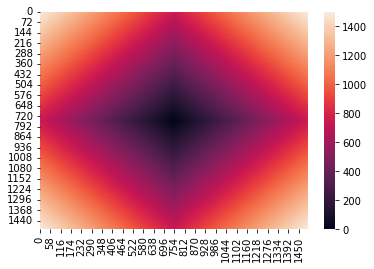

In [8]:
electrode_pixel_size = 40
file = f'../user_files/user_input/image_sequence/pixel_label_PS{electrode_pixel_size}.pkl'
with open(file, 'rb') as f:
    label = pickle.load(f)

rows, columns = label.shape
vertical_dist, horizontal_dist = np.mgrid[np.ceil(-columns/2):np.ceil(columns/2), np.ceil(-rows/2):np.ceil(rows/2)]
dist_matrix = np.abs(vertical_dist) + np.abs(horizontal_dist)
sns.heatmap(dist_matrix)

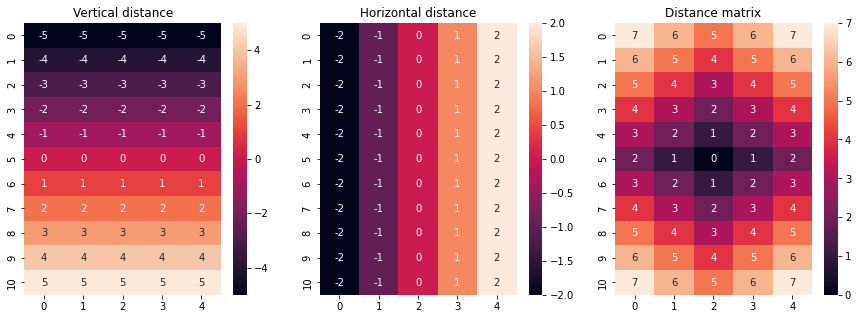

In [15]:
rows, columns = 5, 11
vertical_dist, horizontal_dist = np.mgrid[np.ceil(-columns/2):np.ceil(columns/2), np.ceil(-rows/2):np.ceil(rows/2)]
dist_matrix = np.abs(vertical_dist) + np.abs(horizontal_dist)
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Plotting
sns.heatmap(vertical_dist, annot=True, ax=axes[0]).set(title="Vertical distance")
sns.heatmap(horizontal_dist, annot=True, ax=axes[1]).set(title="Horizontal distance")
sns.heatmap(dist_matrix, annot=True, ax=axes[2]).set(title="Distance matrix")
plt.show()

### The logic
Behind `determine_central_label`
Every pixel at min dist (zoomed in view)

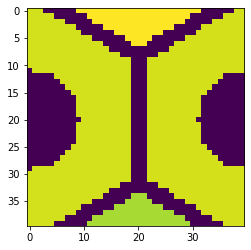

In [23]:
plt.imshow(label[730:770, 730:770])

array([  0,   0,   0, 401, 402,   0,   0,   0])

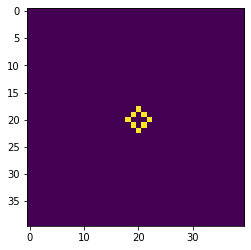

In [24]:
mask = label != 0 
min_dist = np.min(dist_matrix[mask])
# Select all the image pixels at that distance
mask_2 = dist_matrix == min_dist
plt.imshow(mask_2[730:770, 730:770])
central_labels = label[mask_2]
central_labels

In [25]:

electrode_pixel_size = 40
dist_matrix, label = create_distance_matrix(electrode_pixel_size)
central_label = determine_central_label(dist_matrix, label)

# Only keep the central electrode
mask = (label == central_label)

# Create an empty image, except for the central electrode
hexagon_image = Image.fromarray(mask)
# Find the bounding box
bbox = hexagon_image.getbbox()
# Calculate the center coordinates - the middle between the top corners and middle betwen top and bottom corner
center_x = int((bbox[0] + bbox[2]) / 2)
center_y = int((bbox[1] + bbox[3]) / 2)

730 750


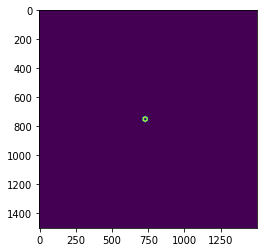

In [27]:
plt.imshow(mask)
print(center_x, center_y)

Call the functions

## Test for gratings

### A first attempt using numpy, which is efficient, but hard to control the pitch

In [11]:
# Working grating with "binary sine wave"

def draw_grating(electrode_pixel_size, wavelength, rotation, position_user):

    path_image = f"../user_files/user_input/image_sequence/Grid_PS{electrode_pixel_size}.png"
    path_label = f"../user_files/user_input/image_sequence/pixel_label_PS{electrode_pixel_size}.pkl"
    
    overlay = Image.open(path_image, 'r')
    projected = Image.new("RGB", overlay.size, "black")
    width, height = overlay.size

    angle_radians = np.deg2rad(rotation)
    spatial_frequency = np.pi * 1/wavelength
    
    # Determine the center of the central hexagon
    hex_center_x, hex_center_y = find_center(electrode_pixel_size)
    center_x, center_y = width // 2, height // 2 # TODO check whether this yields a correct center for odd number

    # Create a straight mesh
    x, y = np.mgrid[0:width, 0:height]
    # Recenter on the central electrode rather than the actual center 
    x -= center_x - hex_center_x
    y -= center_y - hex_center_y
    # Rotate it according to the requested angle
    position = x * np.cos(angle_radians) + y * np.sin(angle_radians)
    
    # Get a continuous grating
    grating = np.sin(position * spatial_frequency)
    # Get a binary grating - either full brightness or dark
    grating = np.where(grating > 0, 255, 0)
    grating_image = Image.fromarray(grating.astype(np.uint8))

    # draw red frame around the projected image
    projected.paste(grating_image, mask=grating_image)
    drawing_projection = ImageDraw.Draw(projected)
    drawing_projection.rectangle([0, 0, projected.size[0] - 1, projected.size[1] - 1], outline="red", width=2)

    # Change the background to the pattern
    overlay.paste(grating_image, mask=grating_image)
    
    return overlay, projected

In [15]:
electrode_pixel_size = 40
width_grating = 40 
pitch_grating = 40
wavelength = 100  # Adjust the spatial frequency as needed
rotation = 45  # Adjust the angle of the grating as needed
position_user = (0, 0)

overlay, projected = draw_grating(electrode_pixel_size, width_grating, rotation, position_user)

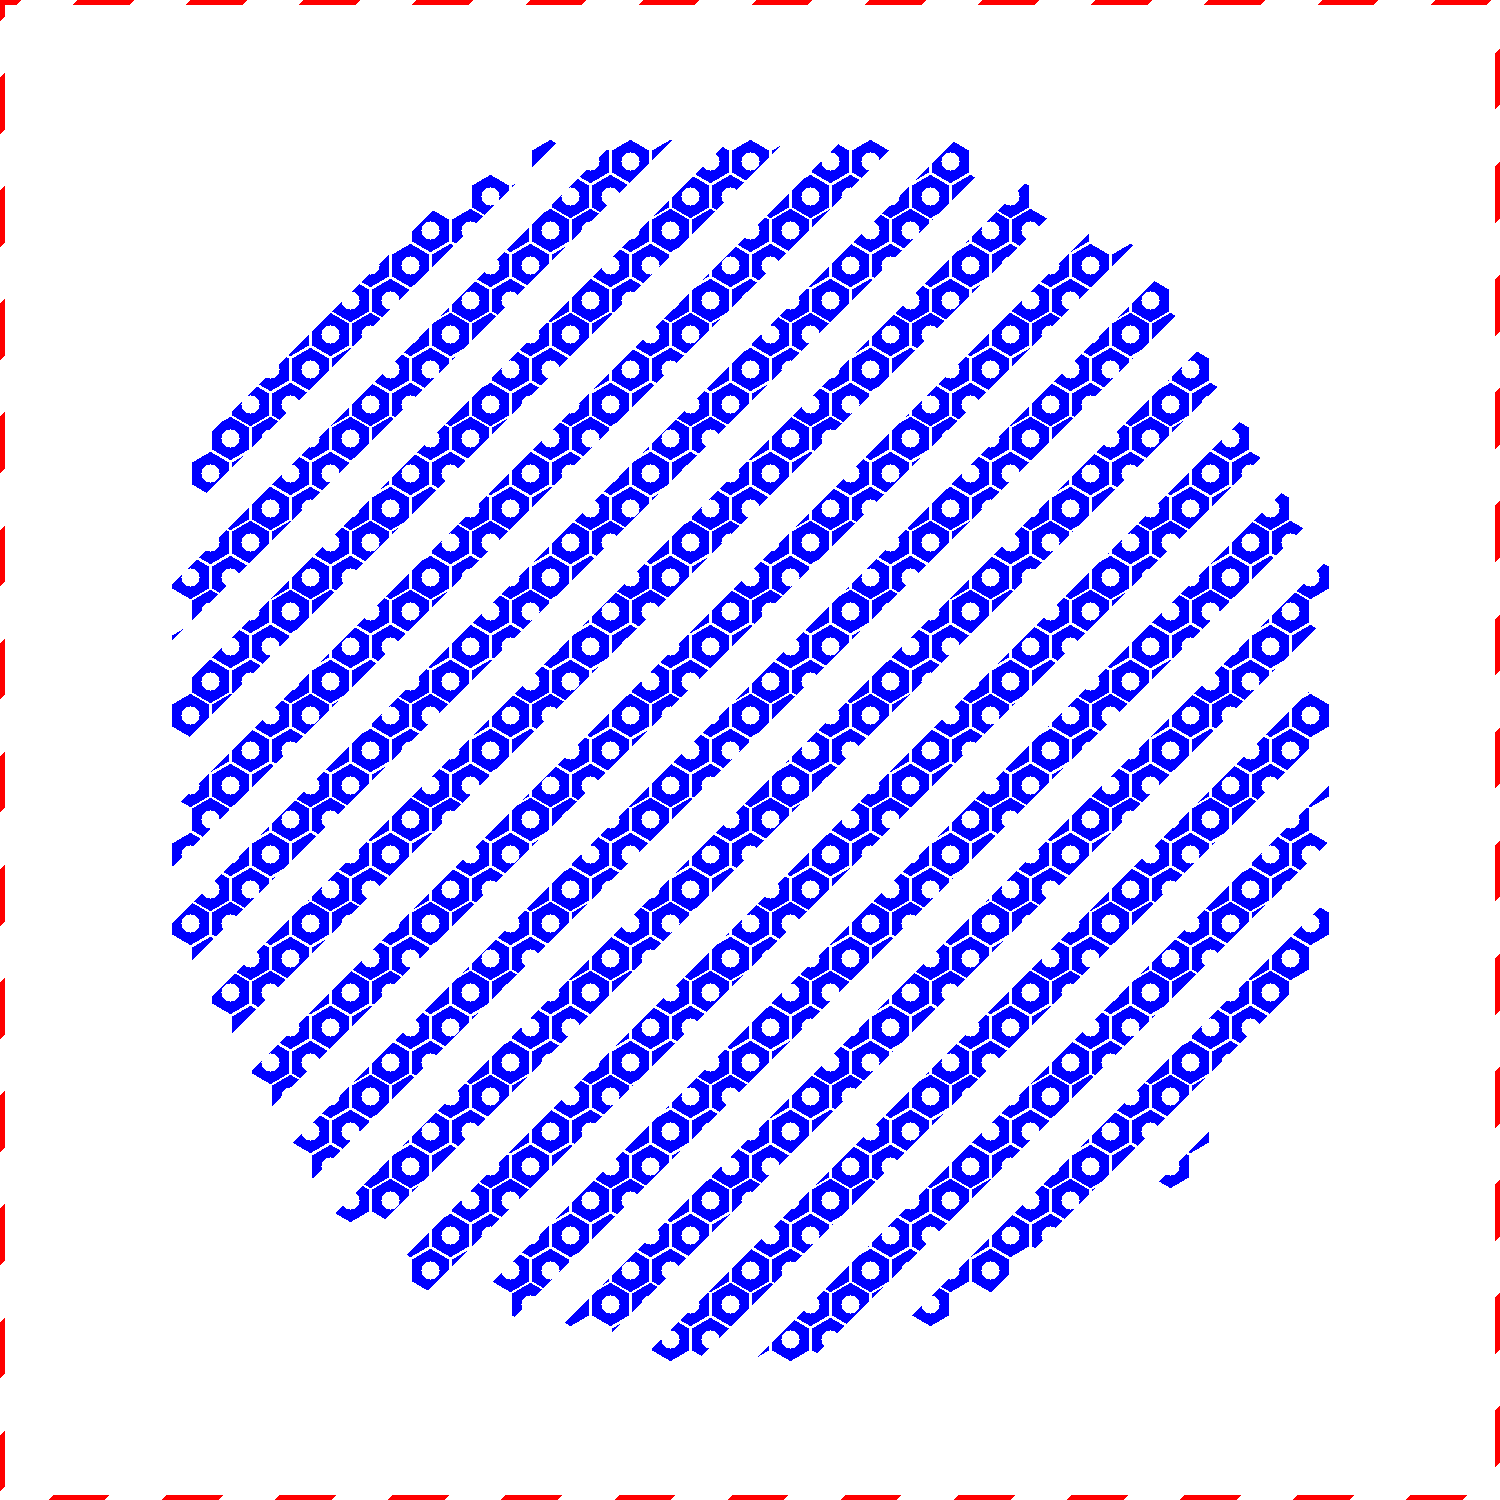

In [16]:
overlay

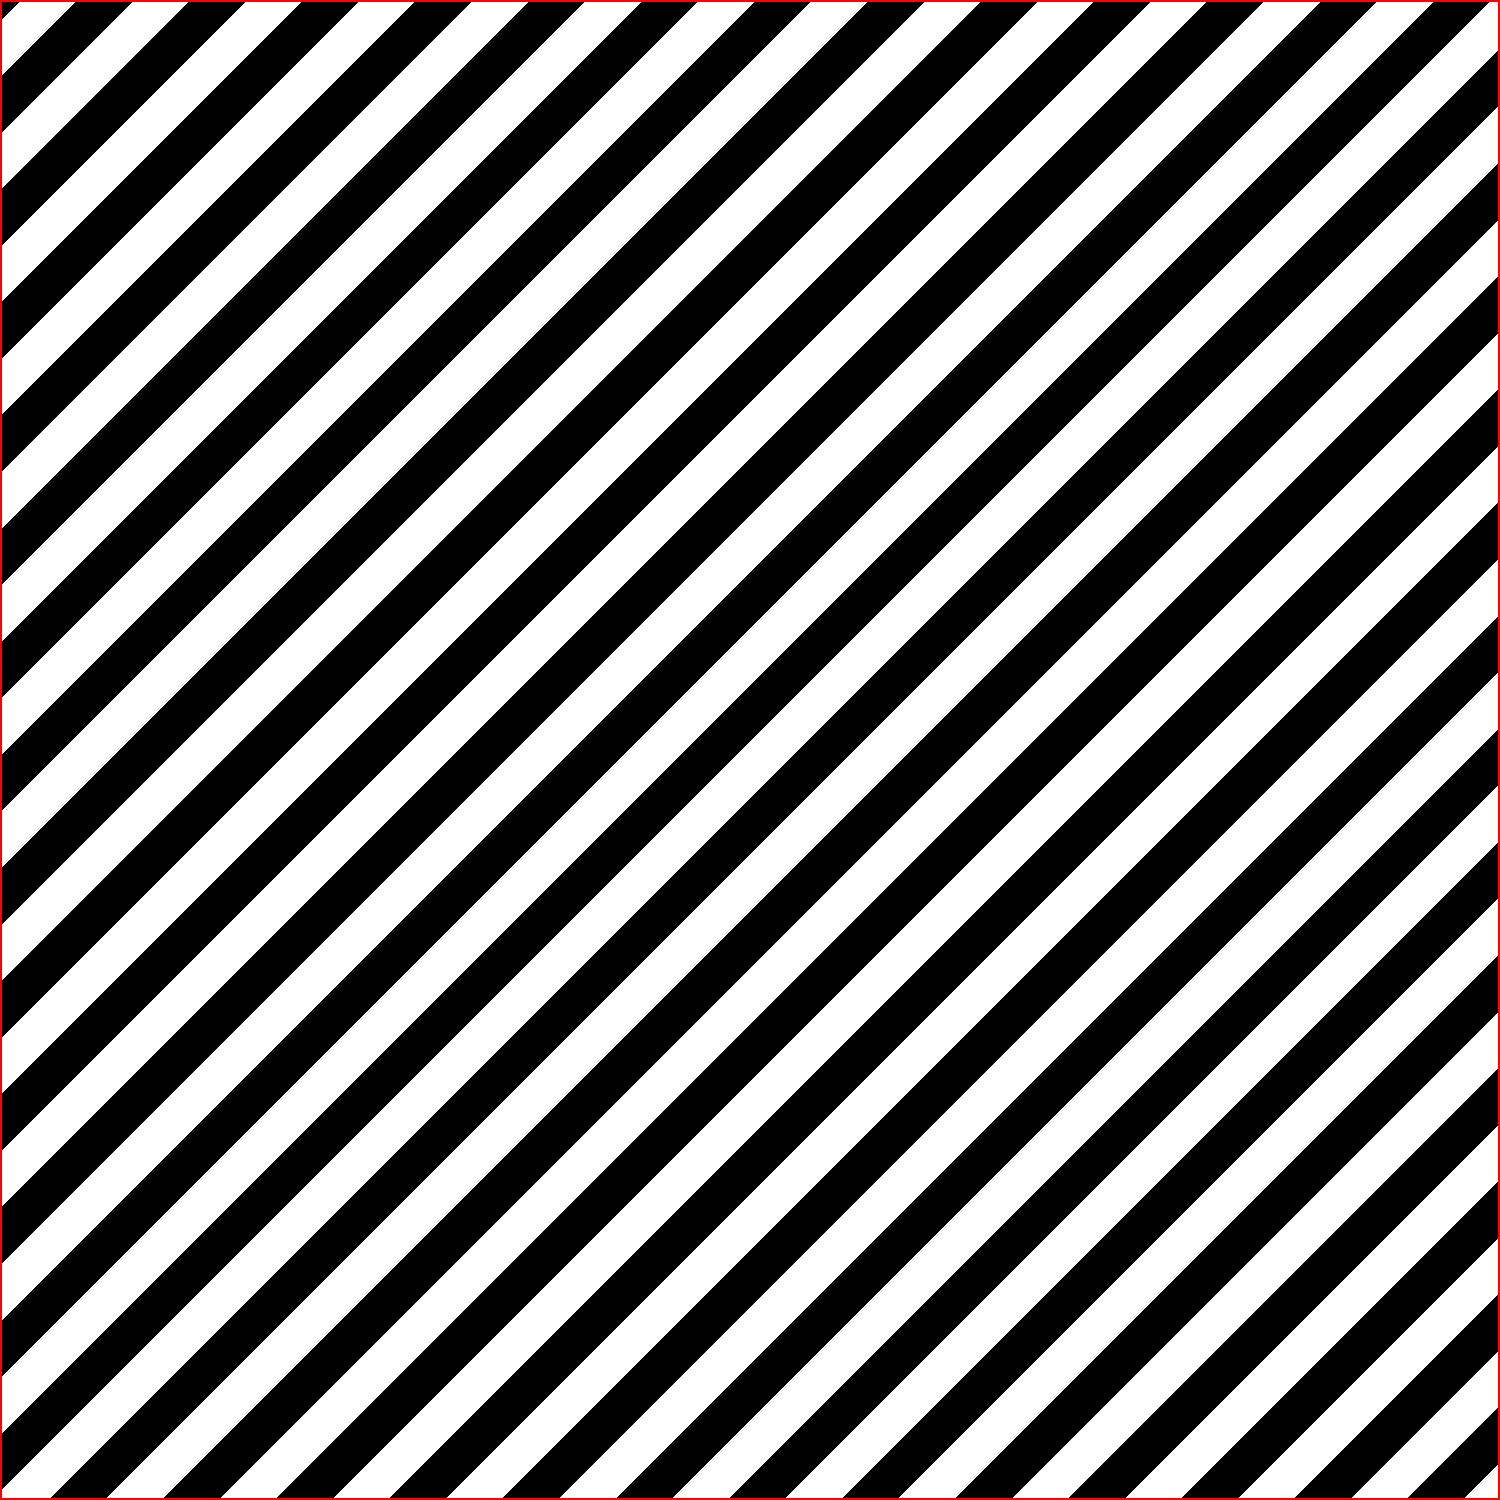

In [17]:
projected

## Working functions

### Drawing letters

In [2]:
electrode_pixel_size = 75
text = 'C'
letter_size = 5
position = (0,0)
font, center_x, center_y = determine_location_letter(electrode_pixel_size, text, letter_size, position)
overlay, projected = draw_overlay_projection(electrode_pixel_size, font, (center_x, center_y), text)

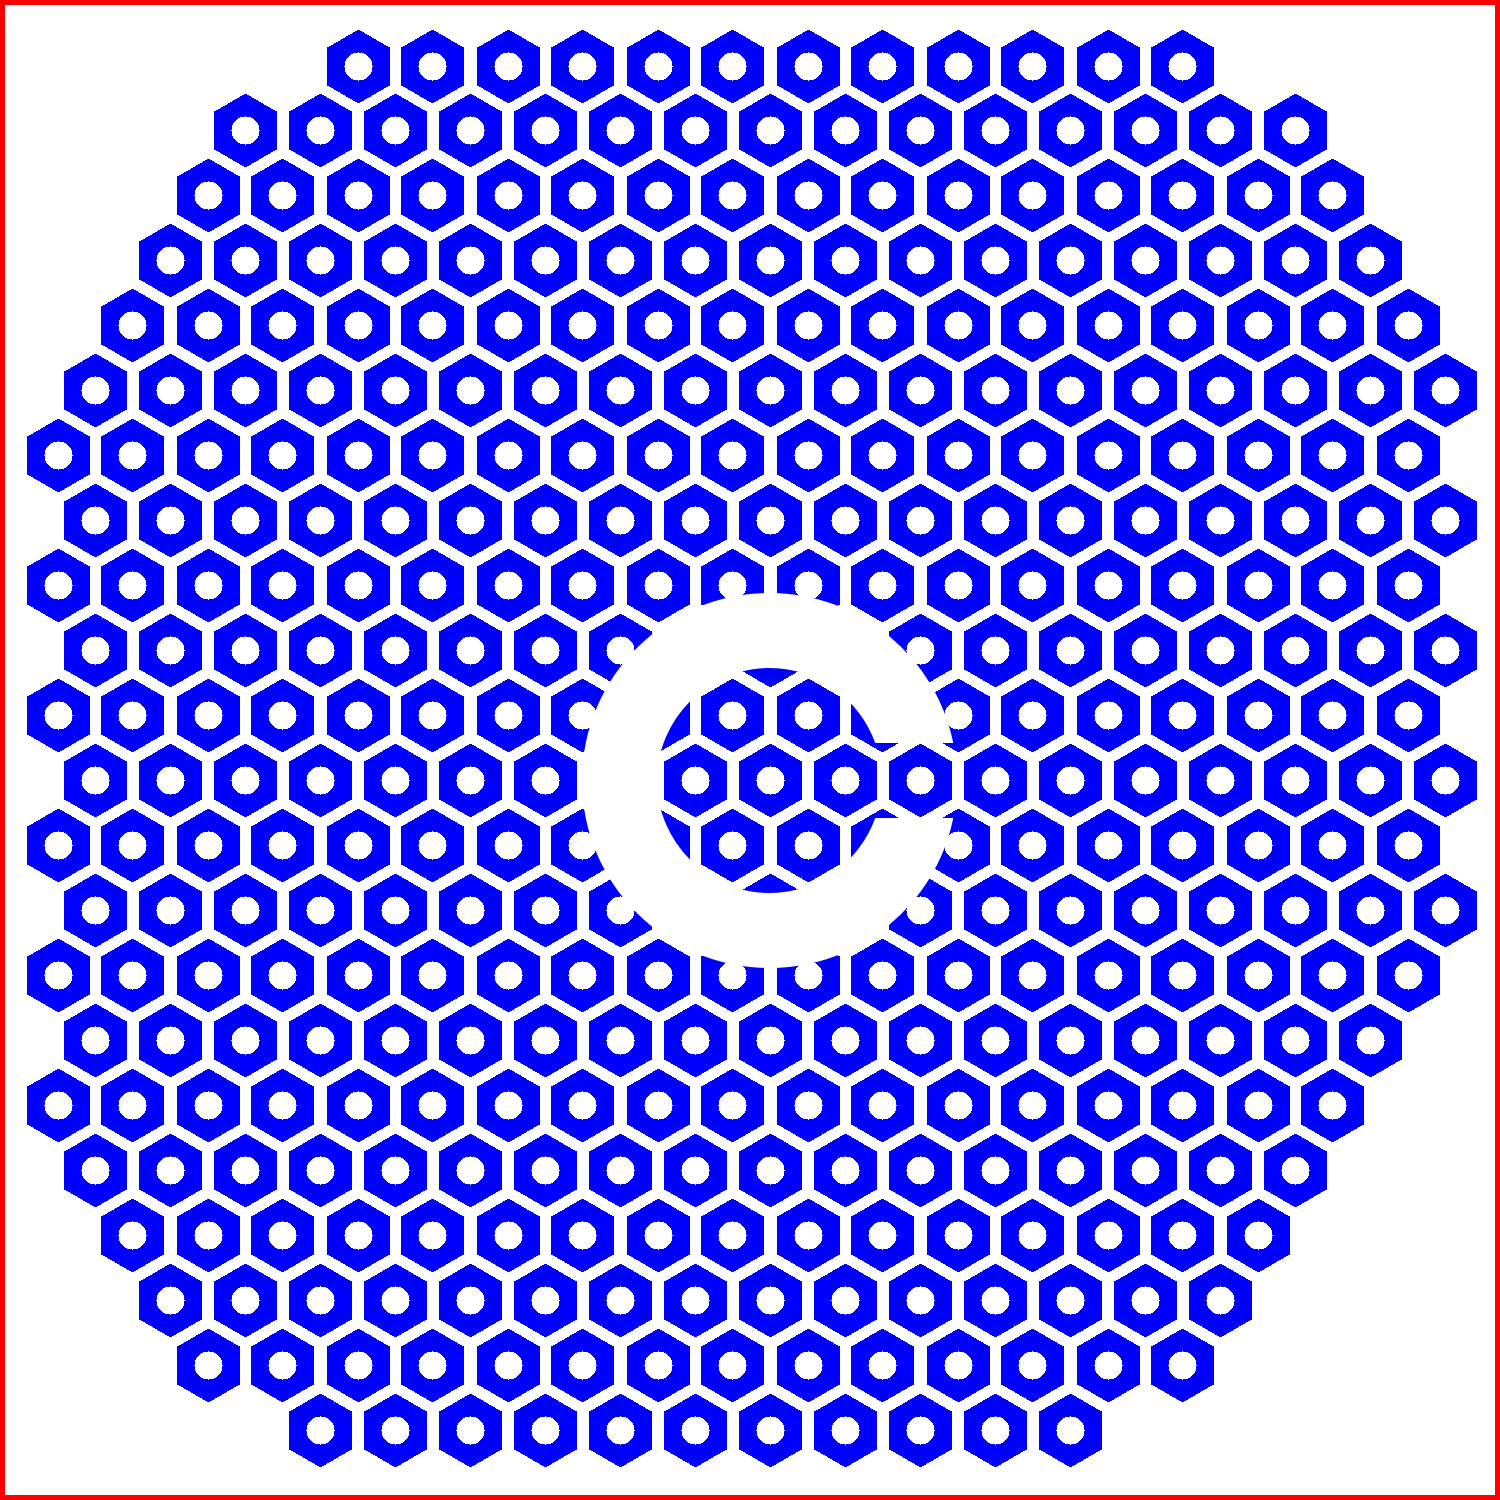

In [3]:
overlay

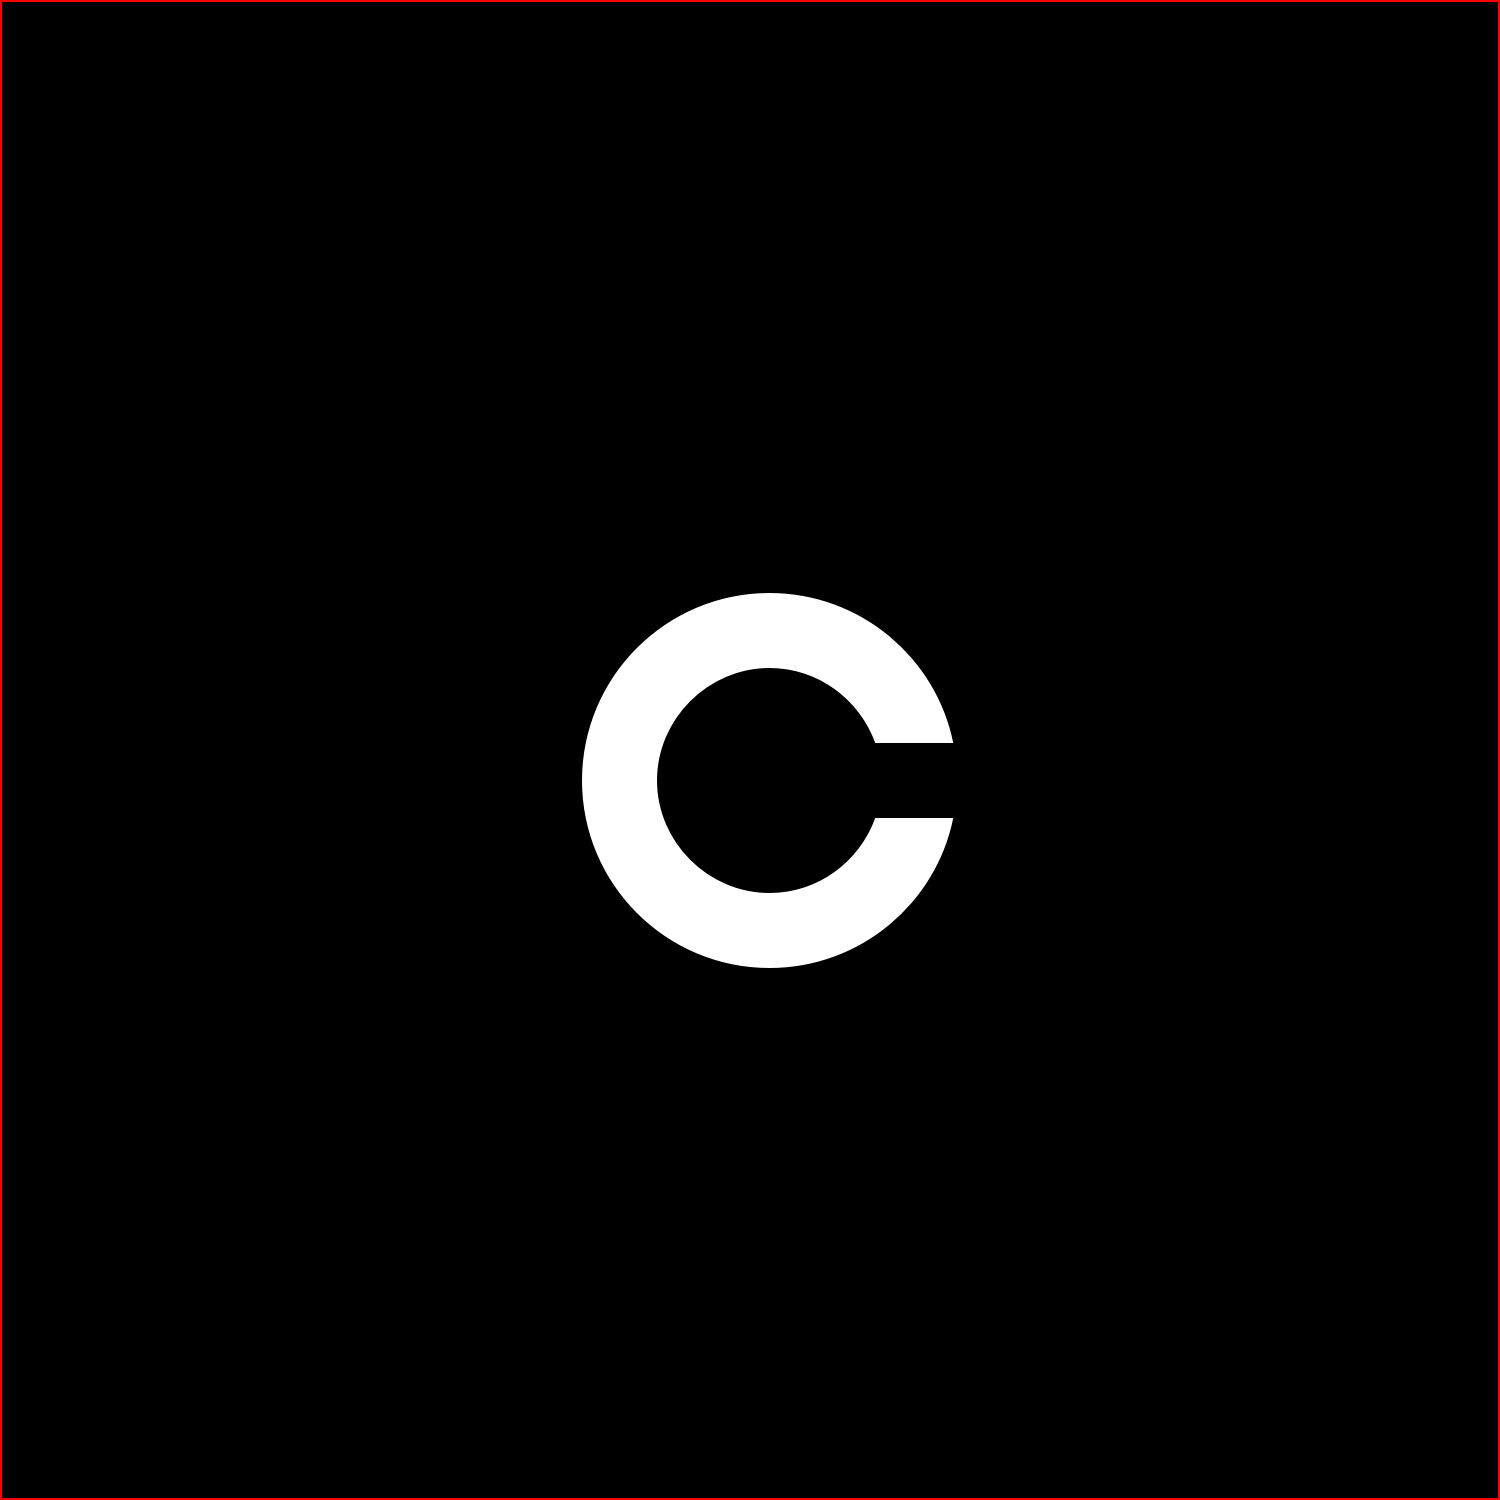

In [4]:
projected

With rotation included

In [5]:
electrode_pixel_size = 40 
letter_size = 5 
position_user = (1.5, -1) 
text = 'C'
rotation = 60
type = "letter"
args = [letter_size, position_user, text, rotation]

overlay_rot, projected_rot = draw_projected_overlay(electrode_pixel_size, type, args)

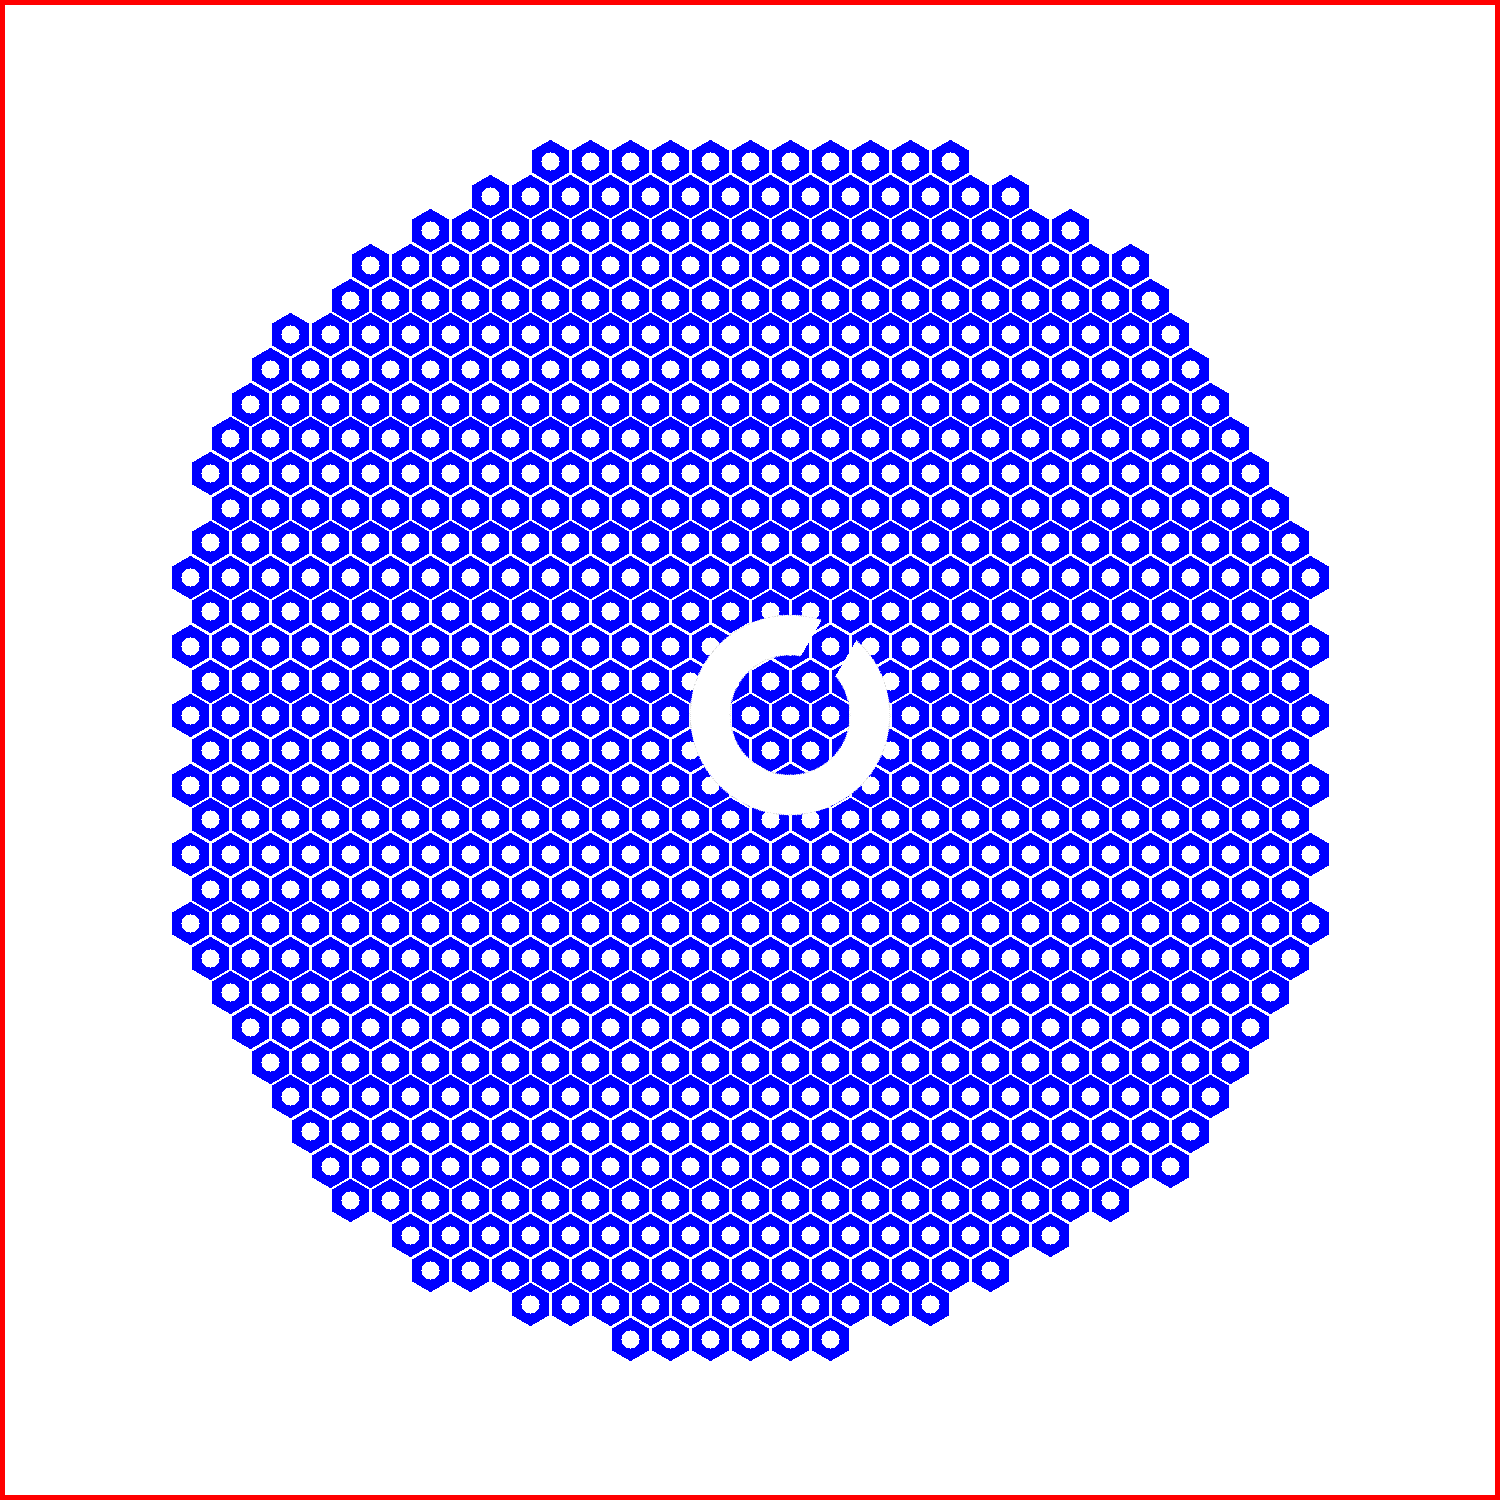

In [6]:
overlay_rot

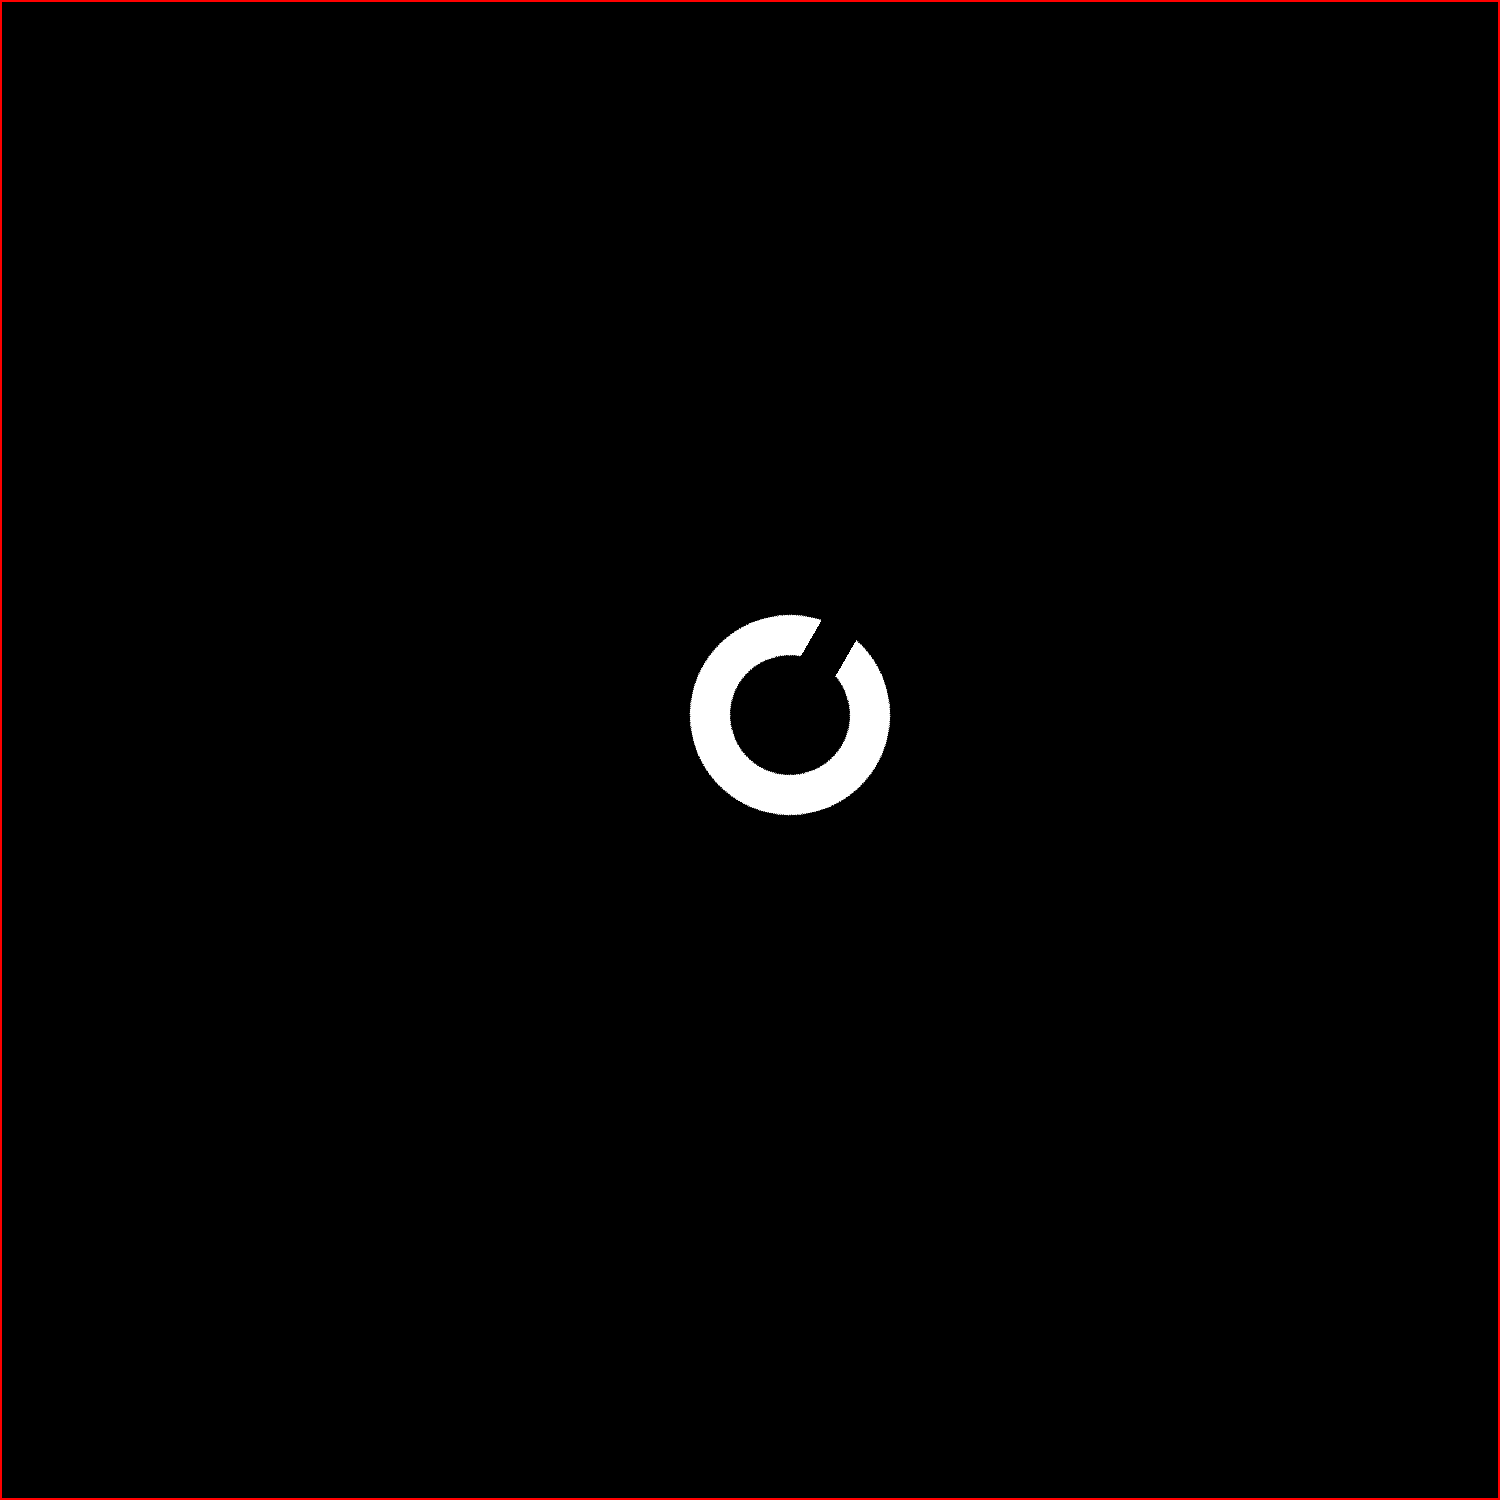

In [7]:
projected_rot

### Drawing gratings

In [8]:
electrode_pixel_size = 75
type = "grating"
width_grating = 75
pitch_grating = 75
rotation = 45
position_user = (0, 0)
args = [width_grating, pitch_grating, rotation, position_user]

overlay, projected = draw_projected_overlay(electrode_pixel_size, type, args)

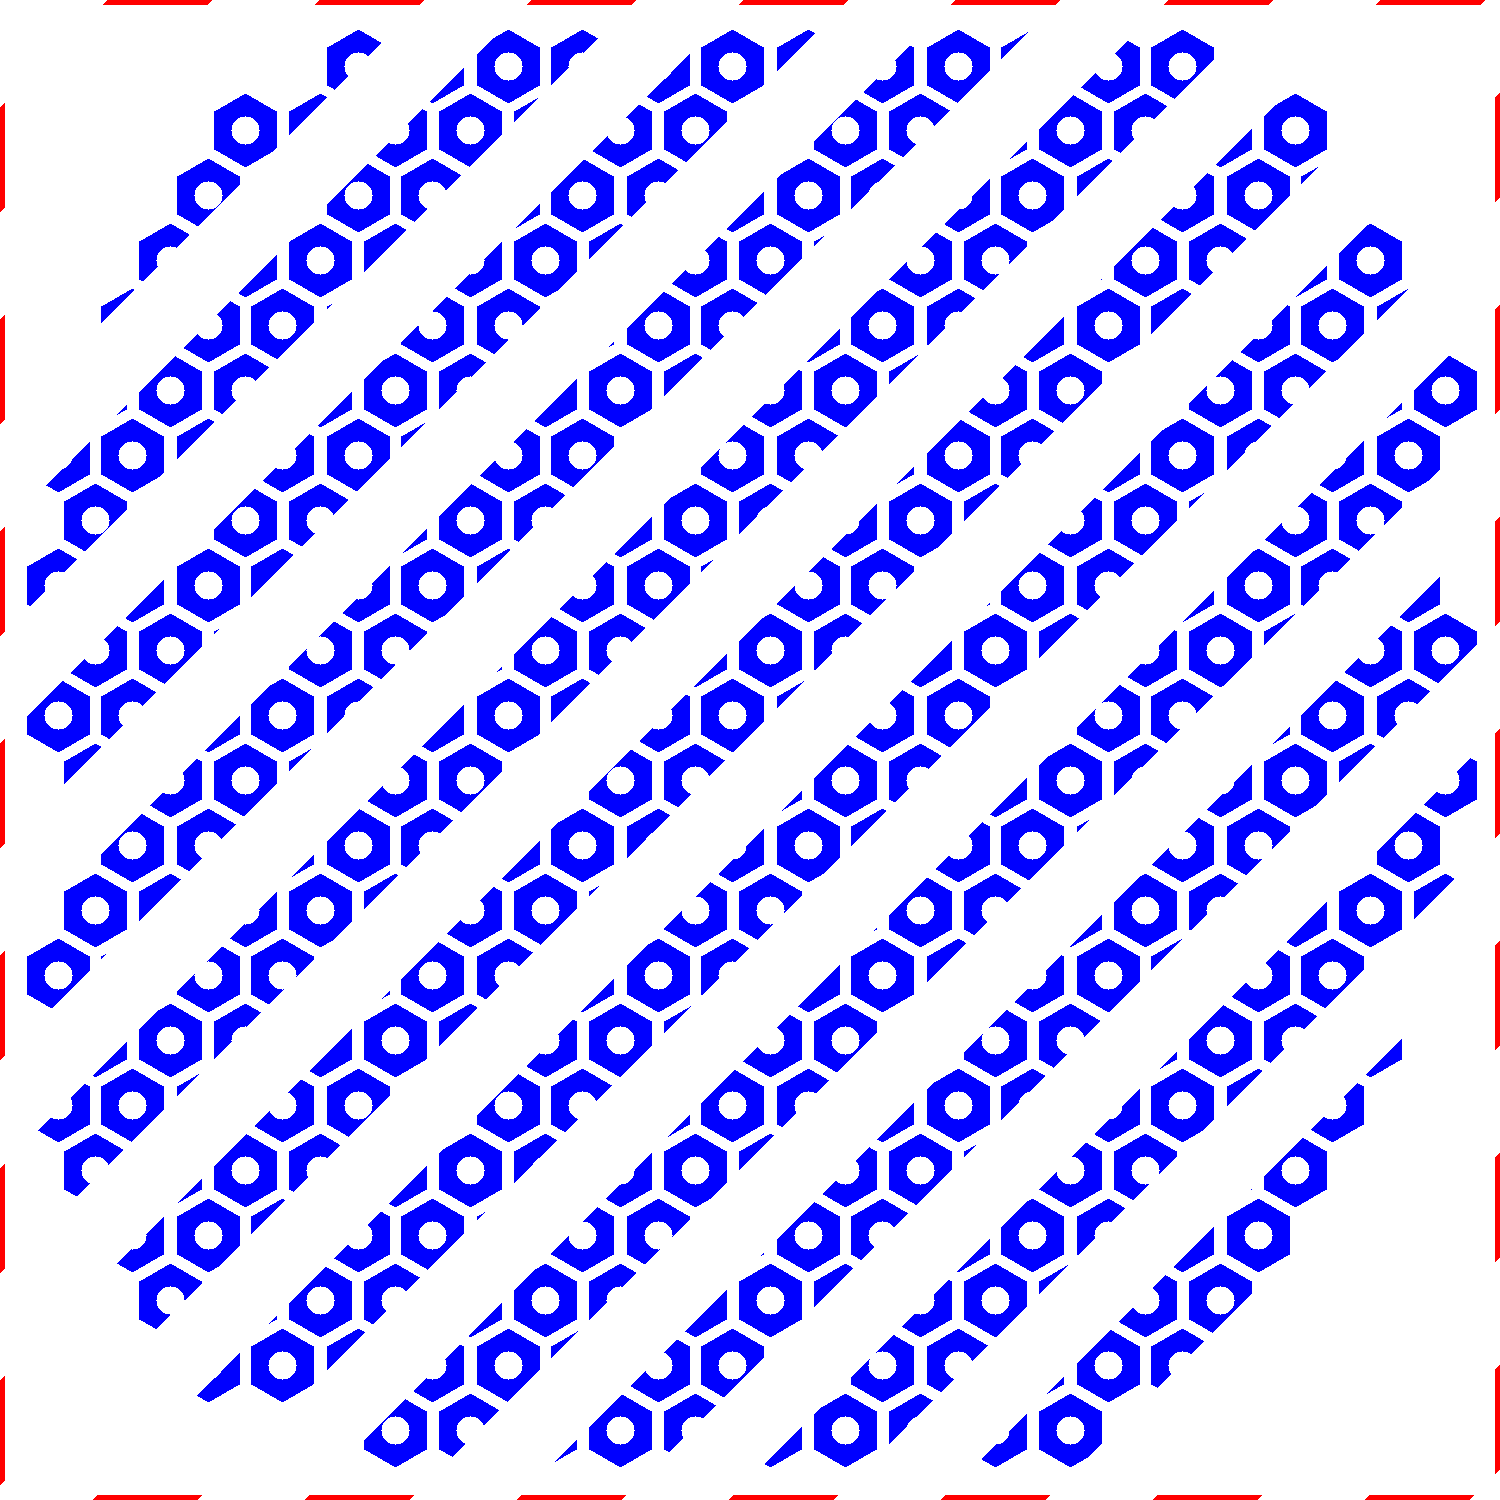

In [9]:
overlay

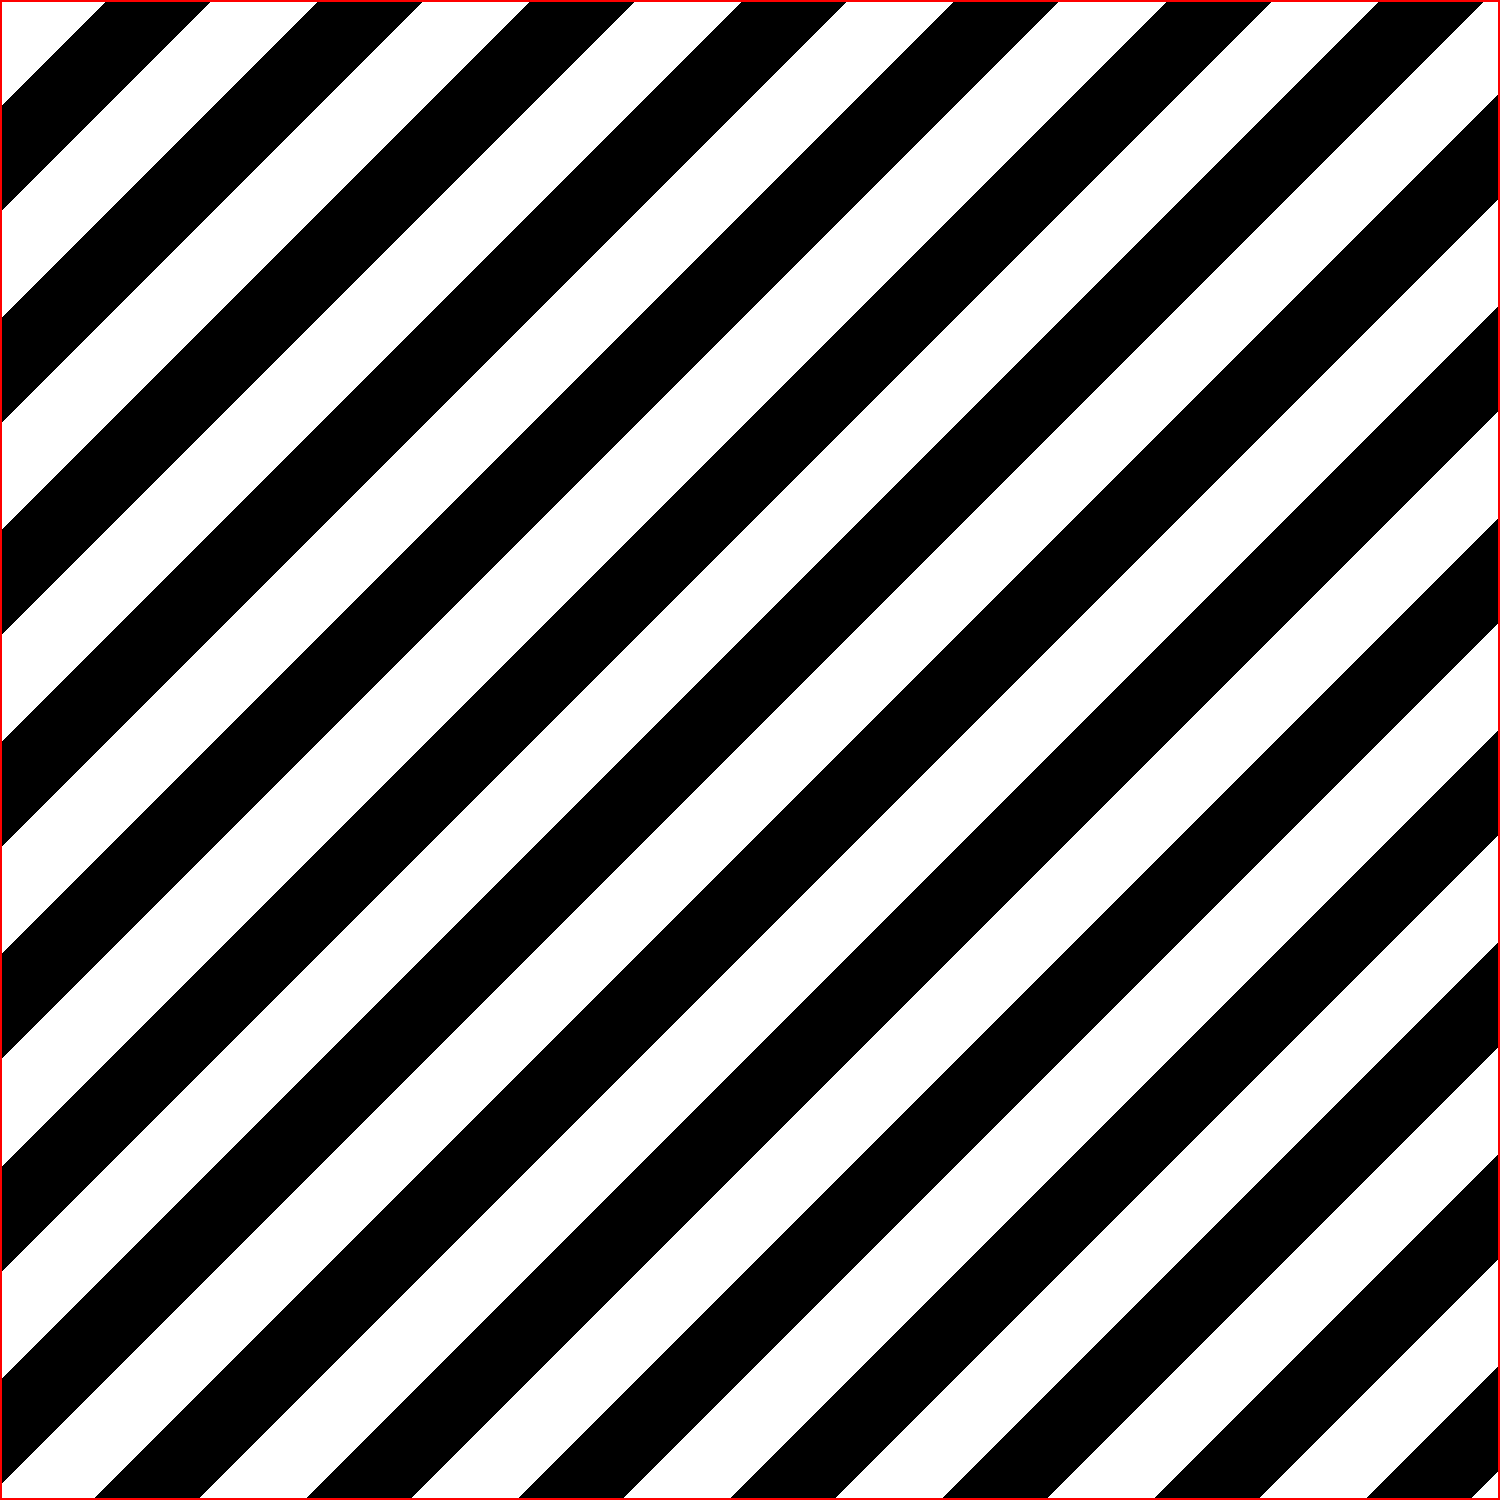

In [10]:
projected